# Introduction
----

Data: https://www.kaggle.com/competitions/feedback-prize-effectiveness/data

**Evaluation**

The first track of this competition focuses on accuracy of classification. Submissions for this track are evaluated using multi-class logarithmic loss. Each row in the dataset has been labeled with one true effectiveness label. For each row, you must submit the predicted probabilities that the product belongs to each quality label.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:


if  torch.cuda.is_available():
    print('Torch available?', torch.cuda.is_available(), torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))
    device = torch.device('cuda:0')
else:
    print('cuda not available - using cpu')
    device = torch.device('cpu')

Torch available? True 1
Quadro P5000


# Data
------

In [3]:
path = 'resources/'
data = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

print('data:', np.shape(data))
display(data.head())
print()
print('test:', np.shape(test))
display(test.head())



data: (36765, 5)


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate



test: (10, 4)


,discourse_id,essay_id,discourse_text,discourse_type
0,a261b6e14276,D72CB1C11673,Making choices in life can be very difficult. ...,Lead
1,5a88900e7dc1,D72CB1C11673,Seeking multiple opinions can help a person ma...,Position
2,9790d835736b,D72CB1C11673,it can decrease stress levels,Claim
3,75ce6d68b67b,D72CB1C11673,a great chance to learn something new,Claim
4,93578d946723,D72CB1C11673,can be very helpful and beneficial.,Claim


In [4]:
data['discourse_effectiveness'].value_counts()

Adequate       20977
Effective       9326
Ineffective     6462
Name: discourse_effectiveness, dtype: int64

<AxesSubplot:ylabel='discourse_type'>

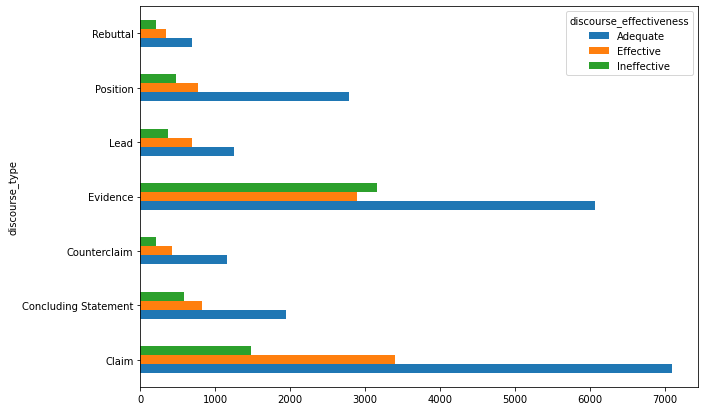

In [6]:
fig, ax = plt.subplots(1,1,figsize=(10,7))

data.groupby('discourse_type')['discourse_effectiveness'].value_counts().unstack(1).plot.barh(ax=ax)

In [7]:
training, validation = train_test_split(data, test_size=0.1, random_state=1234)
print('training:', len(training), 'test:', len(validation))

training: 33088 test: 3677


# Baseline
-----

In [8]:
def baseline(training, validation):
    # baseline: predict probabilites of effectivness for each discourse_type
    props = dict()
    for discourse_type, g in training.groupby('discourse_type'):
        props[discourse_type] = g['discourse_effectiveness'].value_counts()/np.sum(g['discourse_effectiveness'].value_counts())

    y_pred = [list(props[dis_type].values) for dis_type in validation['discourse_type']]
    y_pred_class = [['Adequate', 'Effective', 'Ineffective'][np.argmax(x)] for x in y_pred]
    return log_loss(validation['discourse_effectiveness'], y_pred), accuracy_score(validation['discourse_effectiveness'], y_pred_class)



In [10]:
ll, acc = baseline(training, validation)
print('log-loss = %.3f, accuracy = %.3f'%(ll, acc))

log-loss = 0.965, accuracy = 0.565


# BERT

-----

In [14]:
!git remote -v

origin	https://github.com/gradient-ai/PyTorch.git (fetch)
origin	https://github.com/gradient-ai/PyTorch.git (push)


In [11]:
import transformers



In [12]:
classes = list(np.unique(data))